In [11]:
import itertools
import time
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

%matplotlib inline
plt.style.use('ggplot')

In [13]:
credit = pd.read_csv('Credit.csv', usecols=list(range(1,12)))
credit.head(3)

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
0,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
1,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
2,104.593,7075,514,4,71,11,Male,No,No,Asian,580


In [14]:
credit = pd.get_dummies(credit, columns = ['Gender', 'Student','Married','Ethnicity'],drop_first = True)
credit.head(3)

,Income,Limit,Rating,Cards,Age,Education,Balance,Gender_Male,Student_Yes,Married_Yes,Ethnicity_Asian,Ethnicity_Caucasian
0,14.891,3606,283,2,34,11,333,1,0,1,0,1
1,106.025,6645,483,3,82,15,903,0,1,1,1,0
2,104.593,7075,514,4,71,11,580,1,0,0,1,0


## Best subset selection
To perform best selection, we fit separate models for each possible combination of the n predictors and then select the best subset. That is we fit:

All models that contains exactly one predictor
All models that contain 2 predictors at the second step: (nC2)
Until reaching the end point where all n predictors are included in the model
This results in 2n possibilities as this is a power set problem. In our case there are 211=2048 possible combinations

Algorithm
Let M0 denote the null model which contains no predictors, this model simply predicts the sample mean of each observation

For k=1,2,...,n
Fit all (nCk) models that contain exactly k predictors
Pick the best among these (nCk) models, and call it Mk. Here the best is defined as having the smallest RSS, or an equivalent measure
Select the single best model among M0,M1,...,Mn using cross validated predicton error, Cp, BIC, adjusted R2 or any other method.

## Helper function for fitting linear regression (Sklearn)

In [15]:
def fit_linear_reg(X,Y):
    #Fit linear regression model and return RSS and R squared values
    model_k = LinearRegression(fit_intercept = True)
    model_k.fit(X,Y)
    RSS = mean_squared_error(Y,model_k.predict(X)) * len(Y)
    R_squared = model_k.score(X,Y)
    return RSS, R_squared

## Implementing Best subset selection (using itertools.combinations)

In [23]:
#Importing tqdm for the progress bar
from tqdm import tnrange, tqdm_notebook
#Initialization variables
Y = credit.Balance
X = credit.drop(columns = 'Balance', axis = 1)
k = 11
RSS_list, R_squared_list, feature_list = [],[], []
numb_features = []

In [24]:
X.columns

Index(['Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education', 'Gender_Male',
       'Student_Yes', 'Married_Yes', 'Ethnicity_Asian', 'Ethnicity_Caucasian'],
      dtype='object')

In [25]:
#Looping over k = 1 to k = 11 features in X
for k in range(1,len(X.columns) + 1):
    #Looping over all possible combinations: from 11 choose k
    for combo in itertools.combinations(X.columns,k):
        tmp_result = fit_linear_reg(X[list(combo)],Y)   #Store temp result 
        RSS_list.append(tmp_result[0])                  #Append lists
        R_squared_list.append(tmp_result[1])
        feature_list.append(combo)
        numb_features.append(len(combo))
        #print(combo)
#RSS_list
#Store in DataFrame
df = pd.DataFrame({'numb_features': numb_features,'RSS': RSS_list, 'R_squared':R_squared_list,'features':feature_list})

In [26]:
df.head()

,numb_features,RSS,R_squared,features
0,1,6.620874e+07,0.214977,"(Income,)"
1,1,2.171566e+07,0.742522,"(Limit,)"
2,1,2.143512e+07,0.745848,"(Rating,)"
3,1,8.370950e+07,0.007475,"(Cards,)"
4,1,8.433963e+07,0.000003,"(Age,)"


## Finding the best subsets for each number of features
Using the smallest RSS value, or the largest R_squared value

In [27]:
df_min = df[df.groupby('numb_features')['RSS'].transform(min) == df['RSS']]
df_max = df[df.groupby('numb_features')['R_squared'].transform(max) == df['R_squared']]
display(df_min.head(3))
display(df_max.head(3))

,numb_features,RSS,R_squared,features
2,1,2.143512e+07,0.745848,"(Rating,)"
12,2,1.053254e+07,0.875118,"(Income, Rating)"
79,3,4.227219e+06,0.949879,"(Income, Rating, Student_Yes)"


,numb_features,RSS,R_squared,features
2,1,2.143512e+07,0.745848,"(Rating,)"
12,2,1.053254e+07,0.875118,"(Income, Rating)"
79,3,4.227219e+06,0.949879,"(Income, Rating, Student_Yes)"


## Adding columns to the dataframe with RSS and R squared values of the best subset

In [28]:
df['min_RSS'] = df.groupby('numb_features')['RSS'].transform(min)
df['max_R_squared'] = df.groupby('numb_features')['R_squared'].transform(max)
df.head()

,numb_features,RSS,R_squared,features,min_RSS,max_R_squared
0,1,6.620874e+07,0.214977,"(Income,)",2.143512e+07,0.745848
1,1,2.171566e+07,0.742522,"(Limit,)",2.143512e+07,0.745848
2,1,2.143512e+07,0.745848,"(Rating,)",2.143512e+07,0.745848
3,1,8.370950e+07,0.007475,"(Cards,)",2.143512e+07,0.745848
4,1,8.433963e+07,0.000003,"(Age,)",2.143512e+07,0.745848


## Plotting the best subset selection process

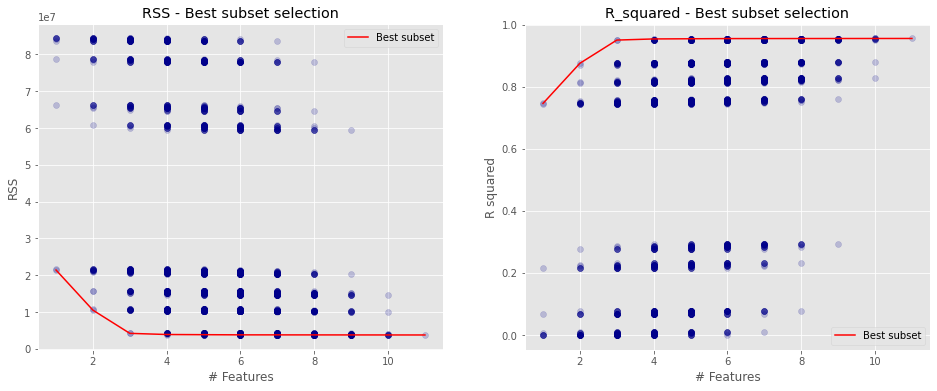

In [29]:
fig = plt.figure(figsize = (16,6))
ax = fig.add_subplot(1, 2, 1)

ax.scatter(df.numb_features,df.RSS, alpha = .2, color = 'darkblue' )
ax.set_xlabel('# Features')
ax.set_ylabel('RSS')
ax.set_title('RSS - Best subset selection')
ax.plot(df.numb_features,df.min_RSS,color = 'r', label = 'Best subset')
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.scatter(df.numb_features,df.R_squared, alpha = .2, color = 'darkblue' )
ax.plot(df.numb_features,df.max_R_squared,color = 'r', label = 'Best subset')
ax.set_xlabel('# Features')
ax.set_ylabel('R squared')
ax.set_title('R_squared - Best subset selection')
ax.legend()

plt.show()

## Forward stepwise selection
For computational reasons, the best subset cannot be applied for any large n due to the 2n complexity. Forward Stepwise begins with a model containing no predictors, and then adds predictors to the model, one at the time. At each step, the variable that gives the greatest additional improvement to the fit is added to the model.

Algorithm
Let M0 denote the null model which contains no predictors

For k=1,2,...,n−1
Consider all n−k models that augment the predictors in Mk with one additional predictor
Choose the \textit{best} among these n−k models, and call it Mk+1
Select the single best model among M0,M1,...,Mn using cross validated predicton error, Cp, BIC, adjusted R2 or any other method.

In [30]:
#Initialization variables
Y = credit.Balance
X = credit.drop(columns = 'Balance', axis = 1)
k = 11

remaining_features = list(X.columns.values)
features = []
RSS_list, R_squared_list = [np.inf], [np.inf] #Due to 1 indexing of the loop...
features_list = dict()

for i in range(1,k+1):
    best_RSS = np.inf
    
    for combo in itertools.combinations(remaining_features,1):

            RSS = fit_linear_reg(X[list(combo) + features],Y)   #Store temp result 

            if RSS[0] < best_RSS:
                best_RSS = RSS[0]
                best_R_squared = RSS[1] 
                best_feature = combo[0]

    #Updating variables for next loop
    features.append(best_feature)
    remaining_features.remove(best_feature)
    
    #Saving values for plotting
    RSS_list.append(best_RSS)
    R_squared_list.append(best_R_squared)
    features_list[i] = features.copy()

## Displaying results of the first 4 steps

In [31]:
print('Forward stepwise subset selection')
print('Number of features |', 'Features |', 'RSS')
display([(i,features_list[i], round(RSS_list[i])) for i in range(1,5)])

Forward stepwise subset selection
Number of features | Features | RSS


[(1, ['Rating'], 21435122),
 (2, ['Rating', 'Income'], 10532541),
 (3, ['Rating', 'Income', 'Student_Yes'], 4227219),
 (4, ['Rating', 'Income', 'Student_Yes', 'Limit'], 4032502)]

## Comparing models: AIC, BIC, Mallows'CP
The training set Mean Squared Error (MSE) is generally an underestimate of the test MSE. This is because when we fit a model to the training data using least squares, we specifically estimate the regression coefficients such that the training RSS is minimized. In particular, the training RSS decreases as we add more features to the model, but the test error may not. Therefore the training RSS and R2 may not be used for selecting the best model unless we adjust for this underestimation.

Mallow's Cp
Mallow's Cp is named after Colin Lingwood Mallows and is defined as:

Cp=1m(RSS+2dσ^2)
where σ^2 is an estimate of the variance of the error ϵ associated with each response measurement. Typically σ^2 is estimated using the full model containing all predictors.

Essentially,the Cp statistic adds a penalty of 2dσ^2 to the training RSS in order to adjust for the fact that the training error tends to underestimate the test error. Clearly, the penalty increases as the number of predictors in the model increases, and this is intended to adjust for the corresponding decrease in training RSS. It can be shown that if σ^2 is an unbiased estimate of σ2 then Cp is an unbiased estimate of the test MSE, so we choose the model with the smallest Cp.

Akaike's Information Criteria (AIC)
The AIC criterion is defiend for a large class of models fit by maximum likelihood. In the case of a linear model with Gaussian errors, MLE and least squares are the same thing and the AIC is given by

AIC=1mσ^2(RSS+2dσ^2)
Bayesian Information Criteria (BIC)
BIC is derived from a Bayesian point of view, and looks similar to the Cp and AIC - it is defined (up to irrelevant constants) as:

BIC=1mσ^2(RSS+log(m)dσ^2)
Like Cp and AIC, the BIC will tend to take small values for a model with low test error.

Adjusted R2
Since the R2 always increases as more variables are added, the adjusted R2 accounts for that fact and introduces a penalty. The intuition is that once all the correct variables have been included in the model,additional noise variables will lead to a very small decrase in RSS, but an increase in k and hence will decrease the adjusted R2. In effect, we pay a price for the inclusion of unnecessary variables in the model.

R2a=1−RSS/(m−k−1)TSS/(m−1)=1−(1−R2)m−1m−k−1
 Theoretical justification
Cp, AIC, BIC all have rigorous theoretical justification that rely on asymptotic arguments, i.e. when the sample size m grows very large, whereas the adjusted R2, although quite intuitive, is not as well motivated in statistical theory.

Estimation of σ^2
Using the RSS of the full model with p features, (i.e.the smallest RSS) we estimate σ^2 as:

σ^2=RSSm−p−1

## Combining forward stepwise results into a new DataFrame

In [12]:
df1 = pd.concat([pd.DataFrame({'features':features_list}),pd.DataFrame({'RSS':RSS_list, 'R_squared': R_squared_list})], axis=1, join='inner')
df1['numb_features'] = df1.index

## Computing the C_p, AIC, BIC and R-square adjusted

In [13]:
#Initializing useful variables
m = len(Y)
p = 11
hat_sigma_squared = (1/(m - p -1)) * min(df1['RSS'])

#Computing
df1['C_p'] = (1/m) * (df1['RSS'] + 2 * df1['numb_features'] * hat_sigma_squared )
df1['AIC'] = (1/(m*hat_sigma_squared)) * (df1['RSS'] + 2 * df1['numb_features'] * hat_sigma_squared )
df1['BIC'] = (1/(m*hat_sigma_squared)) * (df1['RSS'] +  np.log(m) * df1['numb_features'] * hat_sigma_squared )
df1['R_squared_adj'] = 1 - ( (1 - df1['R_squared'])*(m-1)/(m-df1['numb_features'] -1))
df1

,features,RSS,R_squared,numb_features,C_p,AIC,BIC,R_squared_adj
1,[Rating],2.143512e+07,0.745848,1,53636.603151,5.495771,5.505750,0.745210
2,"[Rating, Income]",1.053254e+07,0.875118,2,26428.949364,2.707991,2.727949,0.874489
3,"[Rating, Income, Student_Yes]",4.227219e+06,0.949879,3,10714.442485,1.097835,1.127771,0.949499
4,"[Rating, Income, Student_Yes, Limit]",4.032502e+06,0.952188,4,10276.446437,1.052956,1.092871,0.951703
5,"[Rating, Income, Student_Yes, Limit, Cards]",3.866091e+06,0.954161,5,9909.218362,1.015329,1.065222,0.953579
6,"[Rating, Income, Student_Yes, Limit, Cards, Age]",3.821620e+06,0.954688,6,9846.837591,1.008937,1.068809,0.953996
7,"[Rating, Income, Student_Yes, Limit, Cards, Ag...",3.810759e+06,0.954817,7,9868.483418,1.011155,1.081006,0.954010
8,"[Rating, Income, Student_Yes, Limit, Cards, Ag...",3.804746e+06,0.954888,8,9902.248962,1.014615,1.094444,0.953965
9,"[Rating, Income, Student_Yes, Limit, Cards, Ag...",3.798367e+06,0.954964,9,9935.100415,1.017981,1.107789,0.953924
10,"[Rating, Income, Student_Yes, Limit, Cards, Ag...",3.791345e+06,0.955047,10,9966.344067,1.021182,1.120969,0.953891


In [14]:
print(df1['R_squared_adj'].idxmax())
print(df1['R_squared_adj'].max())

7
0.9540098163629882


## Plotting the computed values as a function of number of features

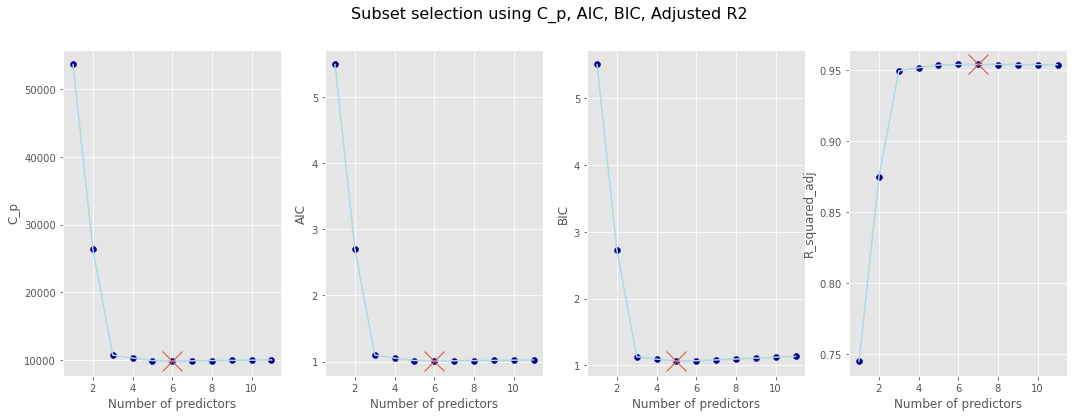

In [15]:
variables = ['C_p', 'AIC','BIC','R_squared_adj']
fig = plt.figure(figsize = (18,6))

for i,v in enumerate(variables):
    ax = fig.add_subplot(1, 4, i+1)
    ax.plot(df1['numb_features'],df1[v], color = 'lightblue')
    ax.scatter(df1['numb_features'],df1[v], color = 'darkblue')
    if v == 'R_squared_adj':
        ax.plot(df1[v].idxmax(),df1[v].max(), marker = 'x', markersize = 20)
    else:
        ax.plot(df1[v].idxmin(),df1[v].min(), marker = 'x', markersize = 20)
    ax.set_xlabel('Number of predictors')
    ax.set_ylabel(v)

fig.suptitle('Subset selection using C_p, AIC, BIC, Adjusted R2', fontsize = 16)
plt.show()

## Pairplot

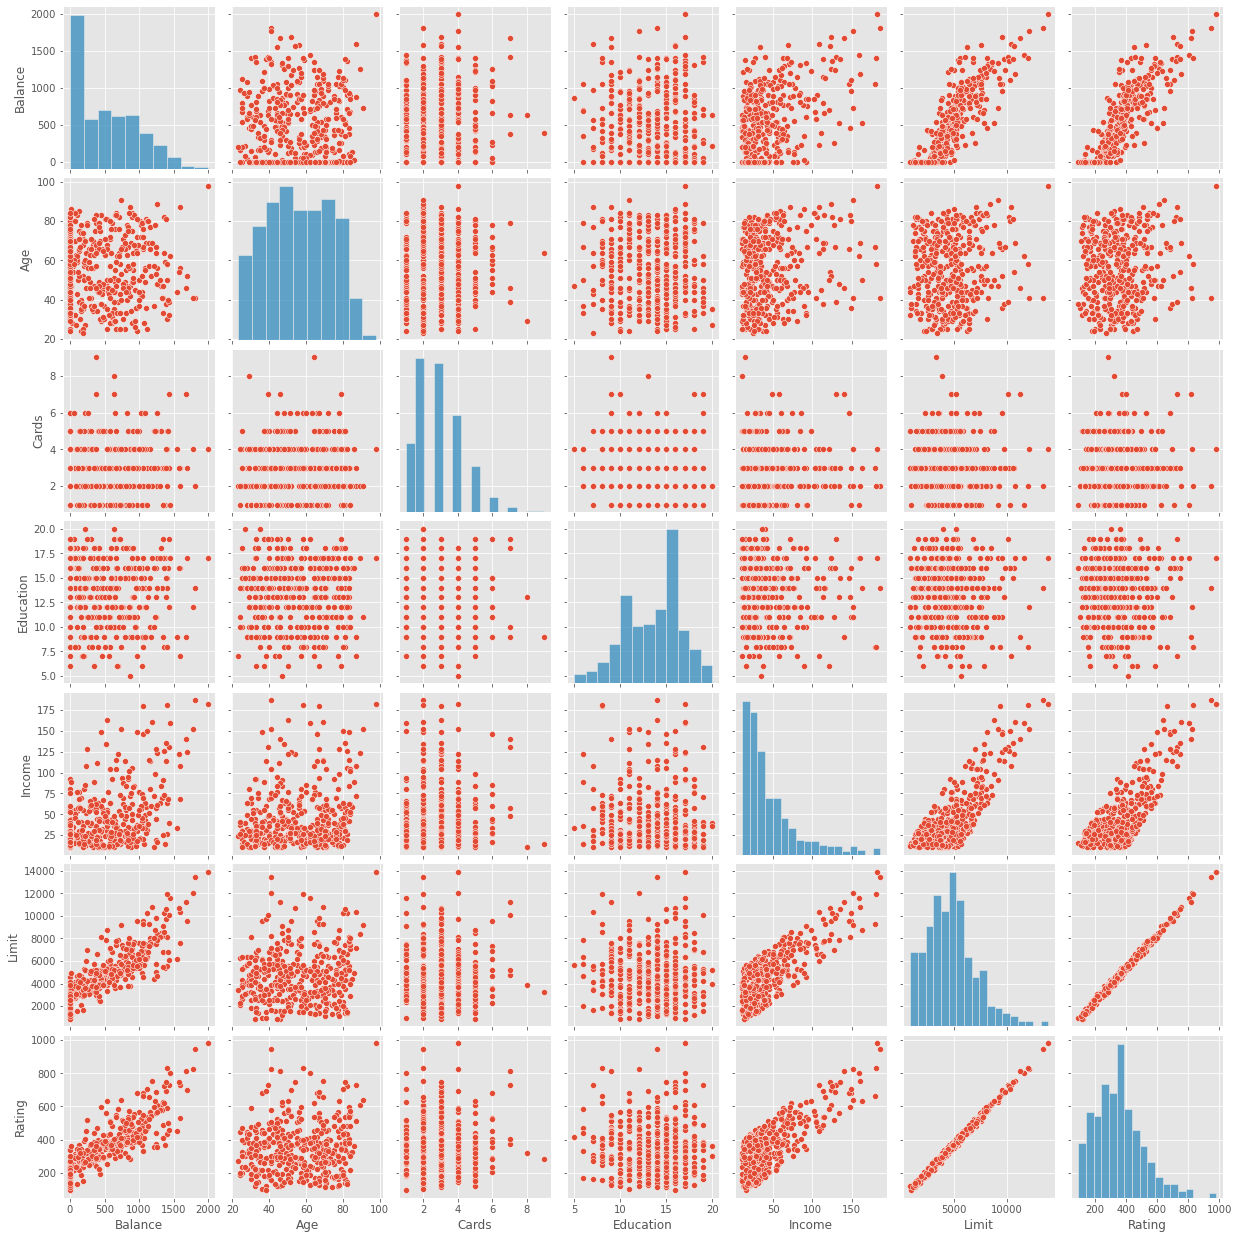

In [16]:
sns.pairplot(credit[['Balance','Age','Cards','Education','Income','Limit','Rating']]);

## Statsmodel linear regression
Least squares coefficient estimates associated with the regression of balance onto ethnicity in the Credit data set.

In [17]:
#Setting up the X and Y variables, adding constant term for intercept
Y = credit.Balance
X = credit[['Ethnicity_Asian','Ethnicity_Caucasian']]
X = sm.add_constant(X)
X.head()

,const,Ethnicity_Asian,Ethnicity_Caucasian
0,1.0,0,1
1,1.0,1,0
2,1.0,1,0
3,1.0,1,0
4,1.0,0,1


In [18]:
model_1 = sm.OLS(Y, X)
result_1 = model_1.fit()
result_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Balance   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                   0.04344
Date:                Sun, 09 May 2021   Prob (F-statistic):              0.957
Time:                        12:30:47   Log-Likelihood:                -3019.3
No. Observations:                 400   AIC:                             6045.
Df Residuals:                     397   BIC:                             6057.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 531.0000     46.319     11.464      0.000     439.939     622.061
Ethnicity_Asian       -18.6863     65.021     -0.287      0.774    -146.515     109.142
Ethnicity_Caucasian   -12.5025     56.681     -0.221      0.826    -123.935      98.930
==============================================================================
Omnibus:                       28.829   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.395
Skew:                           0.581   Prob(JB):                     1.13e-06
Kurtosis:                       2.460   Cond. No.                         4.39
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""